In [1]:
!pip install napari aicsimageio tifffile matplotlib scikit-image==0.17.2

In [2]:
import warnings
warnings.filterwarnings('ignore')

import json

import tifffile
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import napari

from os import getcwd, mkdir, path
from shutil import rmtree

from aicsimageio.readers import CziReader
from skimage import img_as_float, img_as_ubyte

In [3]:
def showXYZprojn(img, voxel_sz_x, voxel_sz_y, voxel_sz_z):
    aspect_xz = voxel_sz_z / voxel_sz_x
    aspect_yz = voxel_sz_z / voxel_sz_y
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 8))

    axes[0].imshow(np.max(img, axis=0), 'gray')
    axes[1].imshow(np.max(img, axis=1), 'gray', aspect=aspect_xz)
    axes[2].imshow(np.max(img, axis=2), 'gray', aspect=aspect_yz)
    plt.show()

## Import Confocal Microscopic Image of the Tissue

Set `CONFOCAL_TISSUE_IMAGE` to the path of the image file to be processed.

In [4]:
CONFOCAL_TISSUE_IMAGE = 'Datasets/STAB DEC/SW 1SEC2 CA1 A CONTRA.czi'

# image has to be converted to float for processing
if CONFOCAL_TISSUE_IMAGE.split('.')[-1] == 'czi':
    original = CziReader(CONFOCAL_TISSUE_IMAGE)
    original = original.data
    original = img_as_float(np.squeeze(original)[0])
else:
    original = img_as_float(io.imread(CONFOCAL_TISSUE_IMAGE))

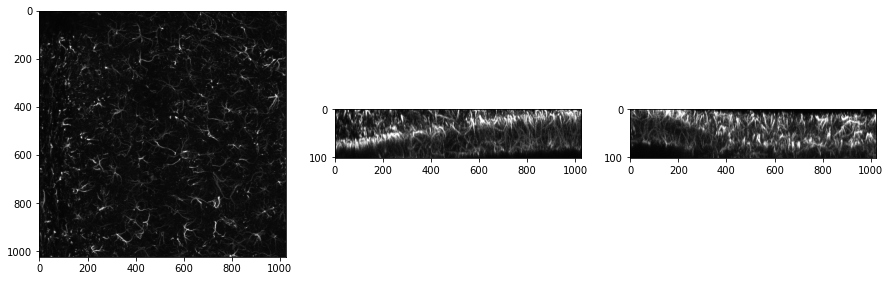

In [5]:
showXYZprojn(original, .5, .5, 1)

## Denoise with Global parameters

### 1. Calibrating Denoisers Using J-Invariance

In [6]:
from skimage.restoration import calibrate_denoiser, denoise_nl_means, estimate_sigma

original_max_projection = np.max(original, 0)
sigma_est = estimate_sigma(original_max_projection)

parameter_ranges = {'h': np.arange(.8, 1.2, .2) * sigma_est,
                    'patch_size': np.arange(2, 6),  # higher, lesser particles
                    'patch_distance': np.arange(2, 6)}  # lesser, more branching maintained

denoiser = calibrate_denoiser(original_max_projection, denoise_nl_means, parameter_ranges)
denoise_parameters = denoiser.keywords['denoiser_kwargs']
denoise_parameters

{'h': 0.017506666757888208, 'patch_size': 4, 'patch_distance': 2}

### 2. Denoise with Non-local means using calibrated parameters

In [7]:
denoised = np.zeros(original.shape)

for i in range(denoised.shape[0]):
    denoised[i] = denoise_nl_means(original[i], **denoise_parameters)

In [8]:
with napari.gui_qt():
    viewer = napari.view_image(original, colormap='gray', name='original')
    viewer.add_image(denoised, colormap='inferno', name='denoised')

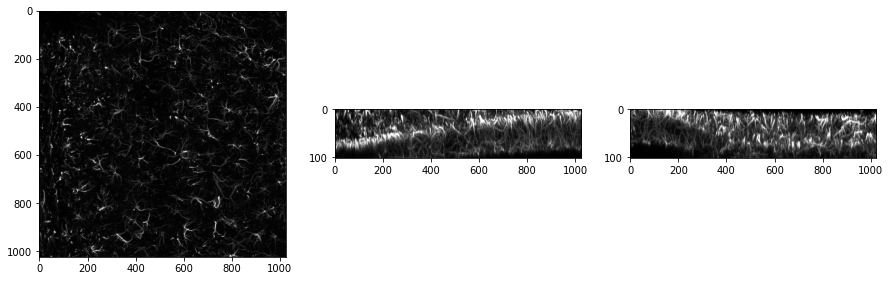

In [9]:
showXYZprojn(denoised, .5, .5, 1)

## Segmentation

### 1. Edge filtering

In [10]:
from skimage.filters import sobel

def sobel_layered(image):
    sobel_edges = np.zeros(image.shape)

    for j in range(image.shape[0]):
        sobel_edges[j] = sobel(image[j])

    return sobel_edges

sobel_edges = sobel_layered(denoised)

In [11]:
with napari.gui_qt():
    viewer = napari.view_image(denoised)
    viewer.add_image(sobel_edges, colormap='inferno')

### 2. Threshold cells

Set two parameters:
- `LOW_THRESH`: Pixel intensity value corresponding to faintest branch's edge
- `HIGH_THRESH`: Pixel intensity value corresponding to faintest soma

In [12]:
from skimage.filters import apply_hysteresis_threshold

LOW_THRESH = .02
HIGH_THRESH = .45

thresholded = apply_hysteresis_threshold(sobel_edges, LOW_THRESH, HIGH_THRESH)

In [13]:
with napari.gui_qt():
    viewer = napari.view_image(denoised)
    viewer.add_image(thresholded, colormap='yellow')

### 3. Segmentation of individual cells

In [14]:
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops

labels = label(thresholded)
# discard artifacts connected to border, potential partially captured
filtered_labels = clear_border(labels)

In [15]:
regions = sorted(regionprops(filtered_labels), key=lambda region: region.area)
print(f'{len(regions)} objects detected.')
max_idx = -10

minz, miny, minx, maxz, maxy, maxx = regions[max_idx].bbox

extracted_cell = denoised[minz:maxz, miny:maxy, minx:maxx].copy()
extracted_cell[~regions[max_idx].filled_image] = 0.0
f'Volume of cell at index {max_idx} is: {regions[max_idx].area}'

98 objects detected.


'Volume of cell at index -10 is: 33907'

In [16]:
with napari.gui_qt():
    viewer = napari.view_image(denoised[minz:maxz, miny:maxy, minx:maxx], name='denoised')
    viewer.add_image(regions[max_idx].image, colormap='yellow', name='thresholded')
    viewer.add_image(extracted_cell, colormap='inferno')

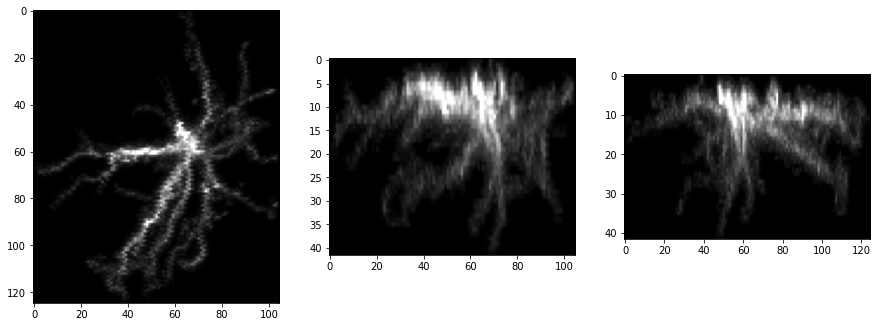

In [17]:
showXYZprojn(extracted_cell, .5, .5, 1)

## Export autocropped 3D cells or 2D max intensity projections

Set two parameters:
- `LOW_VOLUME_CUTOFF`: to filter out noise/artifacts
- `HIGH_VOLUME_CUTOFF`: to filter out cell clusters

For choosing between 3D segmented cells or 2D max intensity projections:
- Set `OUTPUT_OPTION` = 0 for 3D cells, or
- Set `OUTPUT_OPTION` = 1 for Max Intensity Projections.

In [18]:
LOW_VOLUME_CUTOFF = 1600  # filter noise/artifacts
HIGH_VOLUME_CUTOFF = 33000  # filter cell clusters

OUTPUT_OPTION = 0  # 0 for 3D cells, 1 for Max Intensity Projections
OUTPUT_TYPE = ('3D', 'MIP')[OUTPUT_OPTION]

DIR = getcwd() + '/autocropped/'
if not (path.exists(DIR) and path.isdir(DIR)):
    mkdir(DIR)

IMAGE_NAME = path.basename(CONFOCAL_TISSUE_IMAGE).split('.')[0]
OUTPUT_DIR = DIR + IMAGE_NAME + f'_{OUTPUT_TYPE}/'
if path.exists(OUTPUT_DIR) and path.isdir(OUTPUT_DIR):
    rmtree(OUTPUT_DIR)
mkdir(OUTPUT_DIR)

if CONFOCAL_TISSUE_IMAGE.split('.')[-1] == 'tif':
    with tifffile.TiffFile(CONFOCAL_TISSUE_IMAGE) as file:
        metadata = file.imagej_metadata

    cell_metadata = {}
    cell_metadata['unit'] = metadata['unit']
    cell_metadata['spacing'] = metadata['spacing']
    cell_metadata = json.dumps(cell_metadata)
else:
    cell_metadata = None

for region in regions:
    if LOW_VOLUME_CUTOFF < region.area < HIGH_VOLUME_CUTOFF:
        minz, miny, minx, maxz, maxy, maxx = region.bbox

        segmented = img_as_ubyte(denoised[minz:maxz, miny:maxy, minx:maxx].copy())
        segmented[~region.filled_image] = 0

        out_data = segmented if OUTPUT_TYPE == '3D' else np.max(segmented, 0)

        name = f'{OUTPUT_DIR}cell_{minz}-{maxz}_{miny}-{maxy}_{minx}-{maxx}.tif'
        tifffile.imsave(name, out_data, description=cell_metadata)